# Index
1. [Loading Spectrogram Dataset](#1-loading-spetrogram-dataset-into-pytorch)
2. [Train And Test Functions](#2-train-and-test-functions)
3. [Models](#3-models)
    * 3.1 [Custom Model Training](#31-custom-model-2d-cnn)
    * 3.2 [ResNet18 Training](#32-resnet18-training)
    * 3.3 [ViT Training](#33-vit-training)

## 1. Loading spetrogram dataset into pytorch

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd  /content/drive/'MyDrive'/CV/'CV Project'/'Computer-Vision-Project'/

Mounted at /content/drive
/content/drive/MyDrive/CV/CV Project/Computer-Vision-Project


In [1]:
import random
import os
from os.path import splitext
import csv
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)

device:  cuda


### Peeking into the labels data frame

In [27]:
INPUT_FOLDER = f"{os.getcwd()}/input"
OUTPUT_FOLDER = f"{os.getcwd()}/output_grayscale"

In [28]:
SPECTROGRAMS_FOLDER = f"{OUTPUT_FOLDER}/spectrograms"
data_frame = pd.read_csv(f"{OUTPUT_FOLDER}/labels.csv")

print(data_frame.head(), '\n')
print(data_frame['label'].value_counts().rename(index={0: 'No gun/Fake gun (0)', 1: 'Real gun (1)'}))

                                     file_name  label
0          southcentre_mall_window=1_gun=0.png      0
1   southcentre_mall_window=1_vol=8%_gun=1.png      1
2  southcentre_mall_window=1_vol=35%_gun=1.png      1
3  southcentre_mall_window=1_vol=70%_gun=1.png      1
4          southcentre_mall_window=2_gun=0.png      0 

label
Real gun (1)           6978
No gun/Fake gun (0)    4515
Name: count, dtype: int64


### Creating a custom dataset for the train_loader and test_loader

In [29]:
class CustomDataset(Dataset):
  def __init__(self, data_frame=None, transform=None):
    self.data_frame = data_frame
    self.transform = transform

  def __len__(self):
    return len(self.data_frame)

  def __getitem__(self, idx):
    img_name = self.data_frame.iloc[idx, 0]
    image = Image.open(f'{SPECTROGRAMS_FOLDER}/{img_name}').convert('RGB')
    label = int(self.data_frame.iloc[idx, 1])

    if self.transform:
        image = self.transform(image)

    return image, label

"""
Resize the image to standard size, most pretrained models use 224x224.
If we also use this resolution we can experiment with the built-in pretrained models from torchvision.
"""
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

whole_dataset = CustomDataset(data_frame=data_frame, transform=transform)

# Split the dataset into training and testing sets
train_dataset, test_dataset = train_test_split(whole_dataset, test_size=0.2, random_state=42)

# Create DataLoader instances for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Viridis images

In [14]:
torch.save(train_loader, 'train_loader.pth')

In [15]:
torch.save(test_loader, 'test_loader.pth')

In [3]:
train_loader = torch.load('train_loader.pth')
test_loader = torch.load('test_loader.pth')

### Grayscale images

In [30]:
torch.save(train_loader, 'train_loader_grayscale.pth')

In [31]:
torch.save(test_loader, 'test_loader_grayscale.pth')

In [32]:
train_loader = torch.load('train_loader_grayscale.pth')
test_loader = torch.load('test_loader_grayscale.pth')

### Looking into the dataloaders exactly as pytorch will receive them:

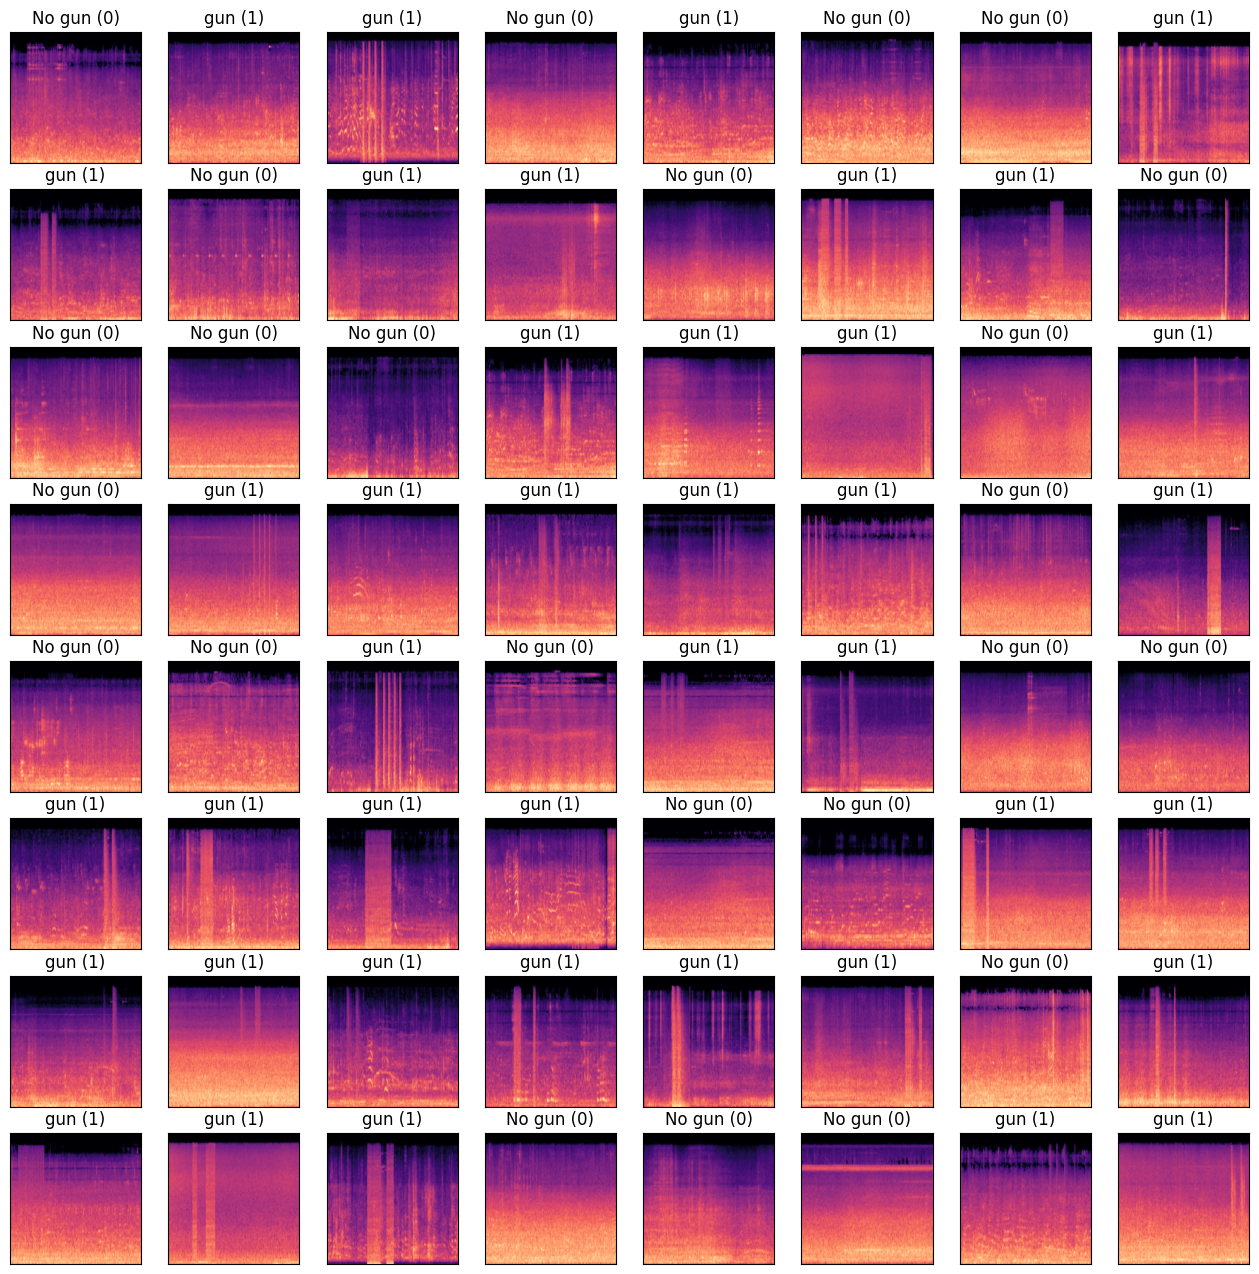

In [4]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# plot images and labels with no padding
fig = plt.figure(figsize=(16, 16))
for idx in np.arange(64):
  ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(f'{"gun (1)" if labels[idx] == 1 else "No gun (0)"}')


## 2. Train and test functions

In [7]:
def train(model, optimizer, train_loader, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      data = data.to(device)
      target = target.to(device)
      target = target.view(target.shape[0], 1).float()

      optimizer.zero_grad()
      output = model(data)
      loss = F.binary_cross_entropy_with_logits(output, target).to(device)
      loss.backward()
      optimizer.step()
      if batch_idx % 25 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

def validation(model, test_loader):
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      target = target.view(target.shape[0], 1).float()
    
      output = model(data)
      validation_loss += F.binary_cross_entropy_with_logits(output, target, reduction="sum").to(device).item() # sum up batch loss
      output = torch.sigmoid(output)
      pred = (target.eq((output>0.5).to(dtype=torch.long)).cpu().sum()) # get the index of the max log-probability
      correct += pred
    
    validation_loss /= len(test_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return 100. * correct / len(test_loader.dataset)

def plot_accuracy(num_epochs, acc_perc_list, filename="plot.png"):
  plt.plot(range(num_epochs+1), acc_perc_list)
  plt.xlim([0,num_epochs+1])
  plt.ylim([50,100])
  plt.xticks([0, 5, 15, 20])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy %')
  plt.savefig(filename)
  plt.show();

def run(model, optimizer, scheduler, train_loader, test_loader, num_epochs):
  acc_perc_list = []
  acc_perc = validation(model, test_loader)
  acc_perc_list.append(acc_perc)

  for epoch in range(1, num_epochs + 1):
      train(model, optimizer, train_loader, epoch)
      scheduler.step()
      acc_perc = validation(model, test_loader)
      acc_perc_list.append(acc_perc)

  return acc_perc_list
  # plot_accuracy(num_epochs, acc_perc_list)

## 3. Models

### 3.1. Custom Model: 2D CNN

In [13]:
class CustomNet(nn.Module):
    def __init__(self):
      super(CustomNet, self).__init__()
      self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
      self.bn2d1 = nn.BatchNorm2d(64, affine=True)
      self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
      self.bn2d2 = nn.BatchNorm2d(128, affine=True)
      self.fc1 = nn.Linear(56*56*128, 512)
#       self.fc1_5 = nn.Linear(256, 128)
      self.dropout = nn.Dropout()
      self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2)
      x = self.bn2d1(x)

      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2)
      x = self.bn2d2(x)

      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))
#       x = F.relu(self.fc1_5(x))
      x = self.dropout(x)

      x = self.fc2(x)

      return x

model_1 = CustomNet()
model_1 = model_1.to(device)

optimizer = optim.Adam(model_1.parameters(), lr=1e-5, weight_decay=1e-5)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 1, 2)


num_epochs = 20

In [ ]:
acc_perc_list = run(model_1, train_loader, test_loader, num_epochs)


Validation set: Average loss: 0.7028, Accuracy: 954/2307 (41%)

Train Epoch: 1 [0/9225 (0%)]	Loss: 0.746688
Train Epoch: 1 [1600/9225 (17%)]	Loss: 0.736200
Train Epoch: 1 [3200/9225 (34%)]	Loss: 0.697963
Train Epoch: 1 [4800/9225 (52%)]	Loss: 0.754591
Train Epoch: 1 [6400/9225 (69%)]	Loss: 0.708748
Train Epoch: 1 [8000/9225 (86%)]	Loss: 0.738370

Validation set: Average loss: 0.7116, Accuracy: 1186/2307 (51%)

Train Epoch: 2 [0/9225 (0%)]	Loss: 0.696435
Train Epoch: 2 [1600/9225 (17%)]	Loss: 0.728616
Train Epoch: 2 [3200/9225 (34%)]	Loss: 0.674147
Train Epoch: 2 [4800/9225 (52%)]	Loss: 0.719584
Train Epoch: 2 [6400/9225 (69%)]	Loss: 0.651702
Train Epoch: 2 [8000/9225 (86%)]	Loss: 0.492173

Validation set: Average loss: 0.6324, Accuracy: 1492/2307 (65%)

Train Epoch: 3 [0/9225 (0%)]	Loss: 0.679070
Train Epoch: 3 [1600/9225 (17%)]	Loss: 0.517936
Train Epoch: 3 [3200/9225 (34%)]	Loss: 0.600748
Train Epoch: 3 [4800/9225 (52%)]	Loss: 0.576582
Train Epoch: 3 [6400/9225 (69%)]	Loss: 0.506230

In [ ]:
[float(x) for x in acc_perc_list]

[41.3524055480957,
 51.408756256103516,
 64.67273712158203,
 67.57694244384766,
 73.8621597290039,
 61.03164291381836,
 75.55266571044922,
 71.91157531738281,
 75.68270111083984,
 72.82184600830078,
 67.4468994140625,
 73.60208129882812,
 74.07888793945312,
 72.34503936767578,
 73.47203826904297,
 73.9488525390625,
 72.0849609375,
 72.73515319824219,
 73.8621597290039,
 72.86519622802734,
 72.86519622802734]

### 3.2. ResNet18 Training

In [101]:
from torchvision.models import ResNet18_Weights

model_2 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

num_features = model_2.fc.in_features
model_2.fc = nn.Linear(num_features, 1)

for param in model_2.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in model_2.fc.parameters():
    param.requires_grad = True

model_2 = model_2.to(device)

optimizer = optim.Adam(model_2.fc.parameters(), lr=1e-3, weight_decay=1e-4)

num_epochs = 20

In [102]:
acc_perc_list = run(model_2, train_loader, test_loader, num_epochs)


Validation set: Average loss: 0.6969, Accuracy: 1350/2307 (59%)

Train Epoch: 1 [0/9225 (0%)]	Loss: 0.747262
Train Epoch: 1 [1600/9225 (17%)]	Loss: 0.685120
Train Epoch: 1 [3200/9225 (34%)]	Loss: 0.673080
Train Epoch: 1 [4800/9225 (52%)]	Loss: 0.604822
Train Epoch: 1 [6400/9225 (69%)]	Loss: 0.705280
Train Epoch: 1 [8000/9225 (86%)]	Loss: 0.613612

Validation set: Average loss: 0.5859, Accuracy: 1530/2307 (66%)

Train Epoch: 2 [0/9225 (0%)]	Loss: 0.592733
Train Epoch: 2 [1600/9225 (17%)]	Loss: 0.564733
Train Epoch: 2 [3200/9225 (34%)]	Loss: 0.532867
Train Epoch: 2 [4800/9225 (52%)]	Loss: 0.590503
Train Epoch: 2 [6400/9225 (69%)]	Loss: 0.591516
Train Epoch: 2 [8000/9225 (86%)]	Loss: 0.559415

Validation set: Average loss: 0.5507, Accuracy: 1651/2307 (72%)

Train Epoch: 3 [0/9225 (0%)]	Loss: 0.425539
Train Epoch: 3 [1600/9225 (17%)]	Loss: 0.570886
Train Epoch: 3 [3200/9225 (34%)]	Loss: 0.517741
Train Epoch: 3 [4800/9225 (52%)]	Loss: 0.577782
Train Epoch: 3 [6400/9225 (69%)]	Loss: 0.55373

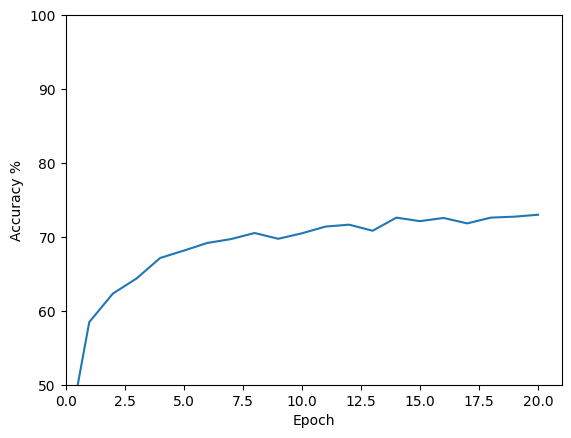

In [ ]:
plot_accuracy(num_epochs, acc_perc_list)

### 3.3. ViT Training

In [27]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

model_3 = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
model_3.heads.head = nn.Linear(768,1,bias=True)
model_3 = model_3.to(device)

optimizer = torch.optim.SGD(model_3.parameters(), lr=1e-4, momentum=0.9)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=1e-8)

num_epochs = 20

In [ ]:
acc_perc_list = run(model_3, optimizer, scheduler, train_loader, test_loader, num_epochs)


Validation set: Average loss: 0.7737, Accuracy: 960/2307 (42%)

Train Epoch: 1 [0/9225 (0%)]	Loss: 0.853399
Train Epoch: 1 [1600/9225 (17%)]	Loss: 0.626714
Train Epoch: 1 [3200/9225 (34%)]	Loss: 0.661719
Train Epoch: 1 [4800/9225 (52%)]	Loss: 0.607211
Train Epoch: 1 [6400/9225 (69%)]	Loss: 0.577078
Train Epoch: 1 [8000/9225 (86%)]	Loss: 0.622170

Validation set: Average loss: 0.5838, Accuracy: 1588/2307 (69%)

Train Epoch: 2 [0/9225 (0%)]	Loss: 0.618367
Train Epoch: 2 [1600/9225 (17%)]	Loss: 0.584404
Train Epoch: 2 [3200/9225 (34%)]	Loss: 0.491300
Train Epoch: 2 [4800/9225 (52%)]	Loss: 0.582435
Train Epoch: 2 [6400/9225 (69%)]	Loss: 0.515911
Train Epoch: 2 [8000/9225 (86%)]	Loss: 0.505207

Validation set: Average loss: 0.4805, Accuracy: 1751/2307 (76%)

Train Epoch: 3 [0/9225 (0%)]	Loss: 0.432981
Train Epoch: 3 [1600/9225 (17%)]	Loss: 0.449771
Train Epoch: 3 [3200/9225 (34%)]	Loss: 0.515618
Train Epoch: 3 [4800/9225 (52%)]	Loss: 0.457044
Train Epoch: 3 [6400/9225 (69%)]	Loss: 0.444884

In [20]:
[float(x) for x in acc_perc_list]

[57.824012756347656,
 70.2210693359375,
 76.46293640136719,
 79.02037048339844,
 82.18465423583984,
 83.44169616699219,
 84.2652816772461,
 84.13523864746094,
 84.1785888671875,
 84.78543853759766,
 85.82574462890625,
 86.30255889892578,
 86.38925170898438,
 86.17251586914062,
 85.9557876586914,
 85.69570922851562,
 86.21586608886719,
 85.13220977783203,
 86.17251586914062,
 85.21890258789062,
 86.73602294921875]